# Load the Data
Load NASDAQ - composite data to test the fitting

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("fitting_test.csv")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
12194,2019-06-12,7803.129883,7819.160156,7773.970215,7792.720215,7792.720215,1952790000
12195,2019-06-13,7822.560059,7848.359863,7813.600098,7837.129883,7837.129883,1838930000
12196,2019-06-14,7807.189941,7819.209961,7778.120117,7796.660156,7796.660156,1804340000
12197,2019-06-17,7819.430176,7865.979980,7812.609863,7845.020020,7845.020020,1935290000
12198,2019-06-18,7920.979980,8005.209961,7911.669922,7953.879883,7953.879883,2244920000


In [3]:
df = df[["Date", "Close"]]
df.tail()

,Date,Close
12194,2019-06-12,7792.720215
12195,2019-06-13,7837.129883
12196,2019-06-14,7796.660156
12197,2019-06-17,7845.020020
12198,2019-06-18,7953.879883


# Normalize the Time

In [4]:
from datetime import datetime

In [5]:
date_to_epoch = lambda x: datetime.fromisoformat(x).timestamp()
epoch_to_date = lambda x: datetime.fromtimestamp(x).strftime("%Y-%m-%d")

In [6]:
df["Date"] = df["Date"].apply(date_to_epoch)
df.tail()

,Date,Close
12194,1.560290e+09,7792.720215
12195,1.560377e+09,7837.129883
12196,1.560463e+09,7796.660156
12197,1.560722e+09,7845.020020
12198,1.560809e+09,7953.879883


# Normalize the Data

In [7]:
df["Close"] /= df["Close"].max()
df["Close"] *= 0.8
df.tail()

,Date,Close
12194,1.560290e+09,0.763618
12195,1.560377e+09,0.767970
12196,1.560463e+09,0.764004
12197,1.560722e+09,0.768743
12198,1.560809e+09,0.779410


# Save the normalized data

In [8]:
df.to_csv("normalized_data.csv")

# Plot the Data

In [9]:
df.plot.scatter("Date", "Close")

# Split the data

In [10]:
import numpy as np

In [11]:
x = df["Date"].array.to_numpy()[:, np.newaxis]
y = df["Close"].array.to_numpy()

# Smooth the data

In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [13]:
model = ExponentialSmoothing(y, trend='add', seasonal=None)
fit = model.fit()

In [14]:
import matplotlib.pyplot as plt

In [15]:
n = 300

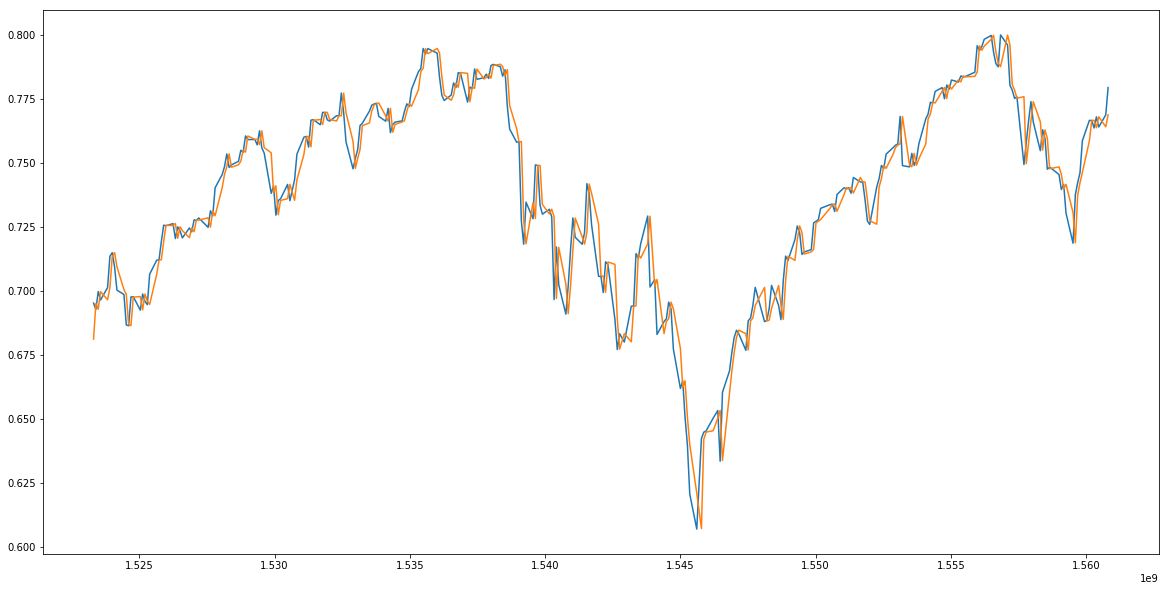

In [16]:
plt.figure(figsize=(20,10))
plt.plot(x[-n:], y[-n:])
plt.plot(x[-n:], fit.fittedvalues[-n:])
plt.show()

In [29]:
y = fit.fittedvalues

# Fit the Data

I guess that a linear model + dft to get periodicity would be enougth

I guess the RANSAC regression is  better because it ignore outliers but this means that it's "slower" to adapt to rapid changes. 

Or if the RANSAC fails a Bayesian regression with well thought prior might be even more robust (BayesianRidge)

https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge

In [30]:
from sklearn.linear_model import RANSACRegressor

Fit the Model

In [31]:
ransac = RANSACRegressor()
ransac.fit(x, y)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

# Analyze the fit

Analyze what is inside and what is outside of the considered data

If the outlier are too much we might want to fall back to a normal linear regression

In [32]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

$$ y = mx+q \qquad \implies \qquad  x = \frac{y - q}{m} $$

In [33]:
m = ransac.estimator_.coef_[0]
q = ransac.estimator_.intercept_
print("y = {m} * x + {q}".format(**locals()))

y = 2.58761402567531e-10 * x + -0.08977662496456858


In [34]:
if m  < 0:
    print("The line is never going to intercept the max")

In [35]:
time_predicted = (1 - q)/m
time_predicted

4211511508.870265

In [36]:
epoch_to_date(time_predicted)

'2103-06-17'

In [37]:
delta = time_predicted - x[-1]
delta

array([2.65070271e+09])

In [38]:
print("Days left: %d"%(delta/(60*60*24)))

Days left: 30679


# Plot the line

In [39]:
# Predict data of estimated models
px1 = np.linspace(x.min(), x.max(), 100)[:, np.newaxis]
py1 = ransac.predict(px1)

px2 = np.linspace(x.max(), time_predicted, 100)[:, np.newaxis]
py2 = ransac.predict(px2)

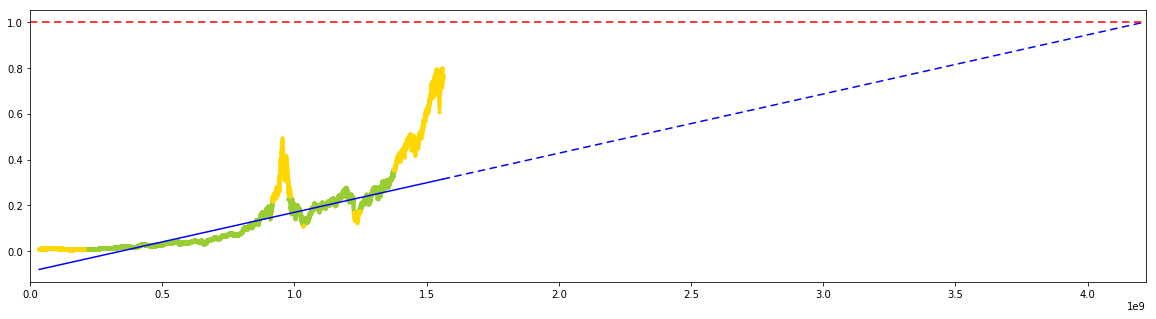

In [40]:
# Set the figure size
plt.figure(figsize=(20,5))

# Print in yellow the data ignored and in green the data used
plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.', label='Inliers')
plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.', label='Outliers')

# Print the prediction
plt.plot(px1, py1, color='blue')
plt.plot(px2, py2, color='blue', dashes=[5,3])

# Print the axes
plt.plot([0,time_predicted], [1,1], color='red', dashes=[5,3])

# Setup the limits
plt.xlim([0,time_predicted + 1e7])

plt.show()